## 平面数据的分类

### 需要的库

这里需要导入的库有：

- numpy：这个不用介绍
- sklearn  这是一个机器学习库，这里主要用来导入需要训练的数据
- matplotlib 不用介绍
- testCases 用来测试各种函数
- planar_utils 主要用来导入数据

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # 设置一个种子保证结果的一致性

### 数据加载

这里主要加载的是一个2维的平面数据，利用提供的planar_utils来获得,这里有两个类，其类型的排布我们可以用散点图绘制出来。
- X是一个二维的数据（x0,x1）其排布有点像花瓣一样
- Y是表示类型0-1两种类型

数据的个数有400个


(2, 400)
(1, 400)
400


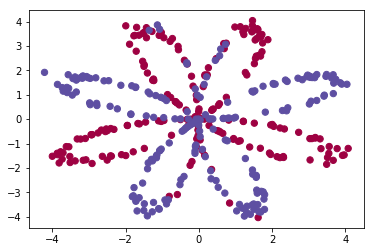

In [12]:
X,Y = load_planar_dataset()

shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1]
print(X.shape)
print(Y.shape)
print(m)

plt.scatter(X[0,:],X[1,:],c=np.squeeze(Y),s=40,cmap=plt.cm.Spectral)

### 使用简单的逻辑回归模型

这里我们仅仅通过logistic regression来做分类，主要是使用sklearn这个库中自带的方法来进行分类。具体函数如下：

In [13]:
# 创建一个线性的逻辑回归模型
clf = sklearn.linear_model.LogisticRegressionCV()
#训练该模型
clf.fit(X.T,Y.T)

D:\Anaconda3\envs\tfgpu\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

测试的精度为：0.470000


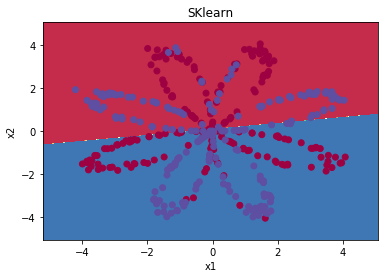

In [21]:
# 
plot_decision_boundary(lambda  x:clf.predict(x),X,np.squeeze(Y))
plt.title("SKlearn")

LR_predictions = clf.predict(X.T)
acc = float(np.sum(LR_predictions==Y))/float(Y.size)
print("测试的精度为：%f" % acc)

### 使用两层的神经网络模型（单个隐含层）


上面的例子可以看出，如果仅仅只是使用单单的sigmoid函数分类，其结果不是很理想，因为其仅仅只能作为一条线的分割。无法做到全类型的分割。所以这里我们需要使用神经网络的方法来实现。这里我们仅仅介绍使用单个隐含层来做处理。
其模型的结构如下：
![](imgs/1.jpg)

上图中的流程可以归纳的数学式子如下：

![](imgs/2.jpg)

为了实现上面的模型的，我们需要做如下工作：

- 定义模型结构：隐含层层数，隐含层的个数
- 参数初始化
- 循环
    - 前向传播，预测函数
    - 损失值计算
    - 反向传播，计算梯度
    - 更新参数

#### 定义模型结构

这里定义2层的神经网络模型
- n_x: 输入层的size，可以通过输入的值确定
- n_h: 隐层层的个数
- n_y: 输出层的size，可以通过输出值确定


In [3]:
# 导入时数据，确定输入和输出的值
X,Y = load_planar_dataset()

print(X.shape)
print(Y.shape)

(2, 400)
(1, 400)


In [11]:
def layer_size(X,Y):
    """
        X,Y:输入输出的值
    """
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    
    return n_x,n_h,n_y

#### 初始化参数

这里需要注意以下几个点：
- 参数的size是否正确：这个需要我们分析W,b的size,其实很好判断，就是根据前面的输出和后面输入来判断
- W权重参数可以使用符合高斯分布的随机数进行初始化：np.random.randn()*0.01
- b偏置值参数直接复制为0

具体操作如下：

In [5]:
def init_para(n_x,n_h,n_y):
    """
    n_x,n_h,n_y:各个层的数据维度
    """
    # 第一层的权重的shape(n_h,n_x)
    # 就是隐含层的个数+输入层的个数
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    # 维度的判断
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    # 保存数据
    parameters={
        "W1":W1,
        "b1":b1,
        "W2":W2,
        "b2":b2
    }
    
    return parameters
    

### 前向传播

这里需要注意的几点是，我们需要自己定义sigmoid函数，这个很简单,
这里我们第一层用到了tanh作为激活函数，可以直接使用numpy自带的函数来实现。

In [6]:
def sigmiod(x):
    return 1.0/1+np.exp(-x)

In [7]:
def forward(X,parameters):
    """
        前向传播，也叫推理
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = np.dot(W1,X)+b1
    #使用tanh函数作为隐藏层的激活函数
    #因为tanh更加让数据接近原点数据，通常情况比sigmoid效果好
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1)+b2
    # 由于要对数据进行二分类，这里选用sigmoid函数
    A2 = sigmoid(Z2)
    
    # 这里简单的判断一下
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {
        "Z1":Z1,
        "A1":A1,
        "Z2":Z2,
        "A2":A2
    }
    
    return A2,cache
    
    

### 损失函数

我们这里选用交叉熵函数（cross_entropy）来计算损失值.

这里有个知识点：
- np.multiply： 表示对应的元素相乘
- np.dot:表示执行矩阵的运算
- * : 
    - 数组\*数组 就是对应位置相乘
    - 矩阵\*矩阵 就是对应矩阵相乘

In [2]:
def  compute_loss(A2,Y,parameter):
    
    # 获得批量数据的个数
    m = Y.shape[1]
    
    # 这里使用numpy的乘法公式
    logprobs = np.multiply(np.log(A2),Y)+np.multiply(np.log(1-A2),(1-Y))
    # numpy sum函数进行计算
    cost = np.sum(logprobs) /m
    
    # 将cost的参数转为正确的size格式，[[12]] = >[12]
    cost = np.squeeze(cost)
    
    assert(isinstance(cost, float))
    
    return cost
        
    

In [3]:
def compute_cost(AL,Y):
    """
    输入：
        AL:最后一层的输出值
        Y:标签数据
    """
    
    m = Y.shape[1]
    # j计算loss值
    cost = -np.sum(np.multiply(np.log(AL),Y)+
                   np.multiply(np.log(1-AL),1-Y))/m
    
    cost = np.squeeze(cost)
    
    return cost

In [6]:
AL = np.array([[0.3,0.4,0.5],[0.3,0.4,0.5],[0.3,0.4,0.5]])
Y = np.array([[0.5,0.3,0.9],[0.2,0.5,0.6],[0.3,0.5,0.6]])

m = Y.shape[1]
print("m:",m)
# j计算loss值
cost = np.multiply(np.log(AL),Y)+np.multiply(np.log(1-AL),1-Y)
print(cost)
cost = -np.sum(cost)/m
print(cost)
print(cost.shape)
cost = np.squeeze(cost)
print(cost)

m: 3
[[-0.78032387 -0.63246516 -0.69314718]
 [-0.52613452 -0.71355818 -0.69314718]
 [-0.6108643  -0.71355818 -0.69314718]]
2.0187819152406075
()
2.0187819152406075


In [2]:
import numpy as np
a = np.array([[1,2,3],[1,2,3]])
print(np.sum(a,axis = 1,keepdims=True))


[[6]
 [6]]


### 反向传播

反向传播是利用链式求导法则来进行计算，通过计算图的方式也是很容易理解。这里直接给出计算公式如下：

![](imgs/3.jpg)

coding 如下：


In [9]:
def backward_propagation(parameters,cache,X,Y):
    
    # 获得批量数据的个数
    m = X.shape[1]
    
    # 获得参数信息
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # 获得中间值信息
    A1 = cache['A1']
    A2 = cache['A2']
    
    #开始反向求导
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2,A1.T)/m
    # axis = 1，表示按照矩阵中列方向求和
    # keepdims = True,让（10，）=>(10,1)
    db2 = np.sum(dZ2,axis = 1,keepdims=True)/m
    # 这里使用的是tanh作为激活函数
    dZ1 = np.dot(W2.T,dZ2)*(1-np.power(A1,2))
    dW1 = np.dot(dZ1,X.T)/m
    db1 = np.sum(dZ1,axis=1,keepdims = True)/m
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads
    
           

### 参数更新

参数更新很简单，就是利用学习率这个超参数来控制每一步变换的幅度$\alpha$
![](imgs/4.jpg)

具体的coding如下：


In [10]:
def update_parameters(parameters,grads,lr = 1.2):
    """
    parameters : 获取的这些参数的数据
    grads: 获取梯度的数据
    lr: 学习率
    """
    
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    
    W1 = W1 - lr*dW1
    b1 = b1 - lr*db1
    W2 = W2 - lr*dW2
    b2 = b2 - lr*db2
    
    parameters = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2}
    
    return parameters

### 建立模型并且训练

下面组合上面的函数建立该模型，并且开始训练获得最终的模型结果


In [14]:
# 两层神经网络的构建和训练（学习）
def nn_model(X,Y,n_h,num_iterations=10000,print_cost=False):
    
    # 获得输入和输出的个数
    n_x = layer_size(X,Y)[0]
    n_y = layer_size(X,Y)[2]
    
    # 初始化参数
    parameters = init_para(n_x,n_h,n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    for i in range(num_iterations):
        
        A2,cache = forward(X,parameters)
        cost = compute_loss(A2,Y,parameters)
        grads = backward_propagation(parameters,cache,X,Y)
        parameters = update_parameters(parameters,grads)
        
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        
    return parameters
    
               

### 推理函数（预测函数）

利用前向传播了构建预测函数

In [15]:
def predict(parameters,X):
    
    A2,cache = forward(X,parameters)
    # 直接返回0,1
    predictions = np.around(A2)
    
    return predictions

### 训练模型并且使用模型

下面开始利用上面介绍的函数来构建一个模型，并将学习好的模型来进行预测

In [16]:
# 构建冰训练模型
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)


Cost after iteration 0: -0.693143
Cost after iteration 1000: -0.281308
Cost after iteration 2000: -0.268974
Cost after iteration 3000: -0.261990
Cost after iteration 4000: -0.257426
Cost after iteration 5000: -0.254274
Cost after iteration 6000: -0.251993
Cost after iteration 7000: -0.250279
Cost after iteration 8000: -0.248951
Cost after iteration 9000: -0.247894


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

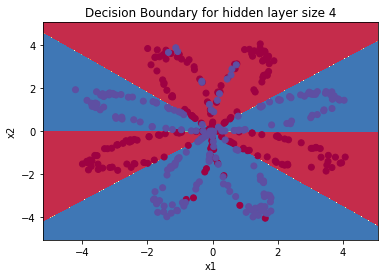

In [18]:
# 利用上面训练好的模型开始预测，并且绘制出模型分类图
plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.squeeze(Y))
plt.title("Decision Boundary for hidden layer size " + str(4))

In [19]:
# 测试模型的精度
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 91%


计算不同的隐藏层个数对模型的影响，

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.75 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.75 %
Accuracy for 50 hidden units: 90.25 %


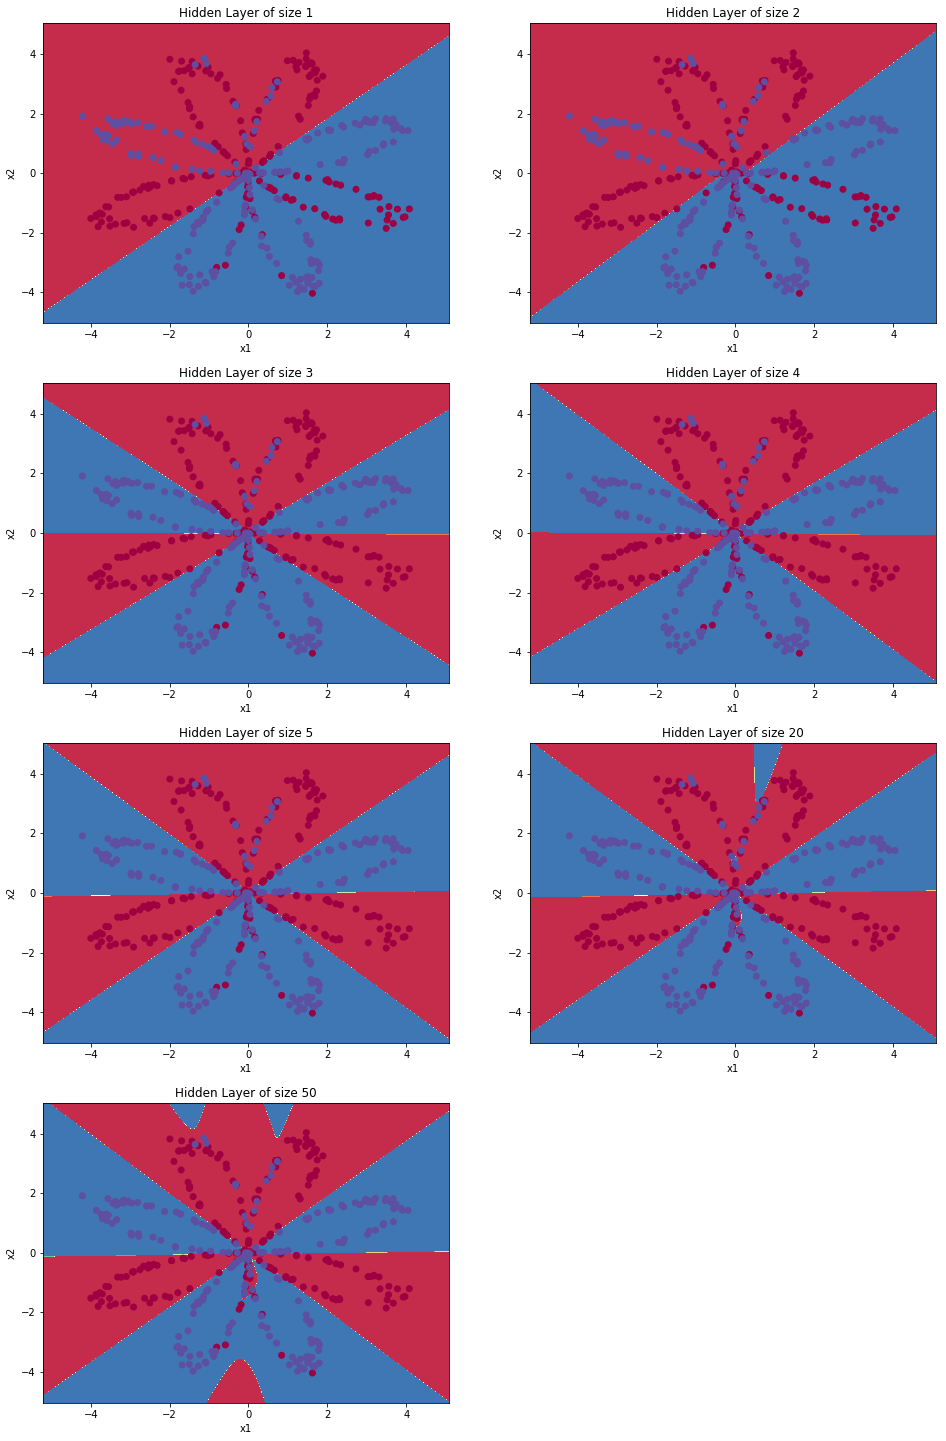

In [21]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.squeeze(Y))
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))